# Metadata

```yaml
Course:   DS 5001
Module:   04 Lab
Topic:    Predict POS with an HMM
Author:   R.C. Alvarado
Date:     5 February 2022 (revised)
```

**Purpose**: Demonstrate Hidden Markov Model applied to POS detection, including the Viterbi algorithm by hand.

# Set Up

In [1]:
data_home = '../data'
data_prefix = 'austen-melville'

In [2]:
OHCO = ['book_id', 'chap_id', 'para_num', 'sent_num', 'token_num']
SENT = OHCO[:4]

In [3]:
import pandas as pd
import numpy as np
import nltk
import re

# Get Annotated `TOKEN` Table

We use the `CORPUS` table from our previous exercise.

In [4]:
TOKEN = pd.read_csv(f"{data_home}/output/{data_prefix}-CORPUS.csv").set_index(OHCO)

In [5]:
TOKEN

pos_tuple  pos  \
book_id chap_id para_num sent_num token_num                                 
105     1       0        0        0                   ('Sir', 'NNP')  NNP   
                                  1                ('Walter', 'NNP')  NNP   
                                  2               ('Elliot,', 'NNP')  NNP   
                                  3                     ('of', 'IN')   IN   
                                  4              ('Kellynch', 'NNP')  NNP   
...                                                              ...  ...   
34970   114     0        50       6                    ('The', 'DT')   DT   
                                  7          ('Ambiguities,', 'NNP')  NNP   
                                  8                     ('by', 'IN')   IN   
                                  9                ('Herman', 'NNP')  NNP   
                                  10             ('Melville', 'NNP')  NNP   

                                                token_str     term_str  
book_id chap_id para_num sent_num token_num                             
105     1       0        0        0                   Sir          sir  
                                  1                Walter       walter  
                                  2               Elliot,       elliot  
                                  3                    of           of  
                                  4              Kellynch     kellynch  
...                                                   ...          ...  
34970   114     0        50       6                   The          the  
                                  7          Ambiguities,  ambiguities  
                                  8                    by           by  
                                  9                Herman       herman  
                                  10             Melville     melville  

[1984036 rows x 4 columns]

# Create Table of POS Tags 

We create a table rrom the Penn Treebank Project list of part-of-speech tags.

## Grab UPenn Codes

We get a text version of the UPenn Codes, or tag set, by calling `nltk.help.upenn_tagset()`. The extra information can be used later in visualizations, etc.

In [6]:
POS = pd.read_csv(f'{data_home}/misc/upenn_tagset.txt', sep='\t', names=['pos_code','def'])
POS = POS[POS.pos_code.str.match(r'^\w')].set_index('pos_code') # Keep only letter codes

In [7]:
# POS

## Add value counts

In [8]:
POS['n'] = TOKEN.pos.value_counts().to_frame().sort_index()
POS['n'] = POS['n'].fillna(0).astype('int')

In [9]:
POS.sort_values('n', ascending=False)

,def,n
pos_code,,
NN,"noun, common, singular or mass",368075
IN,"preposition or conjunction, subordinating",253850
DT,determiner,196237
JJ,"adjective or numeral, ordinal",148862
PRP,"pronoun, personal",114055
RB,adverb,109713
VBD,"verb, past tense",100279
NNP,"noun, proper, singular",94849
VB,"verb, base form",87697


## Create `POS_GROUP` table

We want a simplified list of grammatical categories. We use the first two letters of each code name as our group.

In [10]:
# Add pos_group feature to POS and TOKEN
POS['pos_group'] = POS.apply(lambda x: x.name[:2], 1)
TOKEN['pos_group'] = TOKEN.pos.str[:2]

In [11]:
# Generate new table from it
POS_GROUP = POS.groupby('pos_group').n.sum().to_frame('n')
POS_GROUP = POS_GROUP[POS_GROUP.n > 0]
POS_GROUP['def'] = POS.groupby('pos_group').apply(lambda x: '; '.join(x['def']))
POS_GROUP['p'] = POS_GROUP.n / POS_GROUP.n.sum()
POS_GROUP['i'] = np.log2(1/POS_GROUP.p)
POS_GROUP['h'] = POS_GROUP.p * POS_GROUP.i

In [12]:
POS_GROUP.sort_values('i').style.background_gradient(cmap='YlGnBu')

,n,def,p,i,h
pos_group,,,,,
NN,519390,"noun, common, singular or mass; noun, proper, singular; noun, proper, plural; noun, common, plural",0.261825,1.933323,0.506193
VB,344697,"verb, base form; verb, past tense; verb, present participle or gerund; verb, past participle; verb, present tense, not 3rd person singular; verb, present tense, 3rd person singular",0.173762,2.524812,0.438717
IN,253850,"preposition or conjunction, subordinating",0.127966,2.966165,0.379569
DT,196237,determiner,0.098923,3.337544,0.330161
PR,171122,"pronoun, personal; pronoun, possessive",0.086263,3.535116,0.304949
JJ,158512,"adjective or numeral, ordinal; adjective, comparative; adjective, superlative",0.079906,3.645549,0.291302
RB,115087,"adverb; adverb, comparative; adverb, superlative",0.058016,4.107416,0.238294
CC,80782,"conjunction, coordinating",0.040722,4.618035,0.188057
TO,53731,"""to"" as preposition or infinitive marker",0.027086,5.206314,0.141018


# Extract Model from `TOKEN`

## Remove punctation from `TOKEN`

In [13]:
TOKEN = TOKEN.join(POS, on="pos_group", rsuffix='_y').dropna()

In [14]:
TOKEN

pos_tuple  pos  \
book_id chap_id para_num sent_num token_num                                 
105     1       0        0        0                   ('Sir', 'NNP')  NNP   
                                  1                ('Walter', 'NNP')  NNP   
                                  2               ('Elliot,', 'NNP')  NNP   
                                  3                     ('of', 'IN')   IN   
                                  4              ('Kellynch', 'NNP')  NNP   
...                                                              ...  ...   
34970   114     0        50       6                    ('The', 'DT')   DT   
                                  7          ('Ambiguities,', 'NNP')  NNP   
                                  8                     ('by', 'IN')   IN   
                                  9                ('Herman', 'NNP')  NNP   
                                  10             ('Melville', 'NNP')  NNP   

                                                token_str     term_str  \
book_id chap_id para_num sent_num token_num                              
105     1       0        0        0                   Sir          sir   
                                  1                Walter       walter   
                                  2               Elliot,       elliot   
                                  3                    of           of   
                                  4              Kellynch     kellynch   
...                                                   ...          ...   
34970   114     0        50       6                   The          the   
                                  7          Ambiguities,  ambiguities   
                                  8                    by           by   
                                  9                Herman       herman   
                                  10             Melville     melville   

                                            pos_group  \
book_id chap_id para_num sent_num token_num             
105     1       0        0        0                NN   
                                  1                NN   
                                  2                NN   
                                  3                IN   
                                  4                NN   
...                                               ...   
34970   114     0        50       6                DT   
                                  7                NN   
                                  8                IN   
                                  9                NN   
                                  10               NN   

                                                                                    def  \
book_id chap_id para_num sent_num token_num                                               
105     1       0        0        0                      noun, common, singular or mass   
                                  1                      noun, common, singular or mass   
                                  2                      noun, common, singular or mass   
                                  3           preposition or conjunction, subordinating   
                                  4                      noun, common, singular or mass   
...                                                                                 ...   
34970   114     0        50       6                                          determiner   
                                  7                      noun, common, singular or mass   
                                  8           preposition or conjunction, subordinating   
                                  9                      noun, common, singular or mass   
                                  10                     noun, common, singular or mass   

                                                    n pos_group_y  
book_id chap_id para_num sent_num token_num                        
105     1       0        0      

<img src="images/hmm.png" width="750">

## Create Table of $t_n \rightarrow t_{n+1}$ Transissions ($A$)

**Add sentence boundaries to sequence**

Note that we are breaking our data by adding `<s>` as a key, although 
it is not part of the UPenn tagset. We might consider creating a code 
for sentence beginnings or endings, such as the stop tag in Eistenstein 2019.

In [15]:
A = TOKEN[['pos_group']].join(TOKEN[['pos_group']].shift(-1), lsuffix='_x', rsuffix="_y")\
    .value_counts().to_frame('n').sort_index()

In [16]:
A['cp'] = A.n / A.groupby('pos_group_x').n.sum()  # P(y|x)

In [17]:
A

n        cp
pos_group_x pos_group_y                
CC          CC            110  0.001362
            CD           1115  0.013803
            DT           9258  0.114605
            EX            434  0.005372
            FW              1  0.000012
...                       ...       ...
WP          MD           1134  0.108548
            NN           1453  0.139083
            RB            506  0.048435
            TO            116  0.011104
            VB           5713  0.546856

[205 rows x 2 columns]

In [18]:
AM = A.cp.unstack(fill_value=0)

In [19]:
AM.style.background_gradient(axis=None)

pos_group_y,CC,CD,DT,EX,FW,IN,JJ,LS,MD,NN,RB,RP,TO,UH,VB,WP
pos_group_x,,,,,,,,,,,,,,,,
CC,0.001362,0.013803,0.114605,0.005372,0.000012,0.105828,0.087222,0.000000,0.025266,0.248112,0.103365,0.000025,0.010163,0.000012,0.276163,0.008690
CD,0.059674,0.016124,0.009225,0.000416,0.000083,0.168301,0.097822,0.000000,0.017786,0.514461,0.017786,0.000166,0.010971,0.000000,0.078374,0.008810
DT,0.001075,0.009590,0.002038,0.000117,0.000296,0.013203,0.246406,0.000000,0.002691,0.658887,0.029169,0.000143,0.001422,0.000005,0.033429,0.001529
EX,0.002180,0.001090,0.025348,0.000000,0.000000,0.020714,0.010902,0.000000,0.095121,0.016626,0.029163,0.000000,0.001363,0.000000,0.797220,0.000273
FW,0.042194,0.016878,0.166667,0.000000,0.059072,0.023207,0.075949,0.000000,0.006329,0.436709,0.056962,0.002110,0.004219,0.000000,0.109705,0.000000
IN,0.003798,0.012192,0.359842,0.002387,0.000433,0.038929,0.094591,0.000000,0.014130,0.321974,0.024849,0.000114,0.009888,0.000000,0.110093,0.006780
JJ,0.050943,0.005243,0.024351,0.000820,0.000397,0.092252,0.069856,0.000000,0.009337,0.628728,0.021569,0.000416,0.034124,0.000076,0.060431,0.001457
LS,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0.000000,0.333333,0.000000
MD,0.004544,0.000741,0.011731,0.000064,0.000000,0.013214,0.001354,0.000000,0.000355,0.008154,0.257380,0.000097,0.011957,0.000000,0.690215,0.000193


## Pause to explore

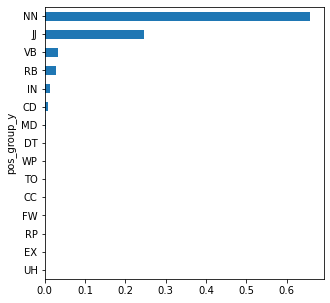

In [20]:
A.loc['DT'].cp.sort_values().plot.barh(figsize=(5,5)); # P(Ty|Tx)

In [21]:
import sys
sys.path.append('../lib')
from hac import HAC

<Figure size 432x288 with 0 Axes>

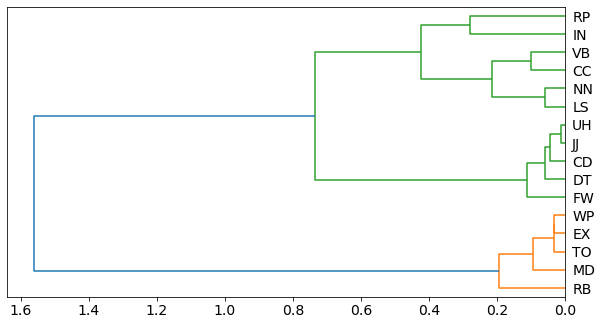

In [22]:
HAC(AM).plot()

In [23]:
POS_GROUP.loc["RP IN VB CC NN LS".split()]

,n,def,p,i,h
pos_group,,,,,
RP,7623,particle,0.003843,8.023638,0.030833
IN,253850,"preposition or conjunction, subordinating",0.127966,2.966165,0.379569
VB,344697,"verb, base form; verb, past tense; verb, pr...",0.173762,2.524812,0.438717
CC,80782,"conjunction, coordinating",0.040722,4.618035,0.188057
NN,519390,"noun, common, singular or mass; noun, proper...",0.261825,1.933323,0.506193
LS,3,list item marker,0.000002,19.334819,0.000029


In [24]:
POS_GROUP.loc[['FW','DT','CD','JJ','UH']]

,n,def,p,i,h
pos_group,,,,,
FW,474,foreign word,0.000239,12.031038,0.002875
DT,196237,determiner,0.098923,3.337544,0.330161
CD,12032,"numeral, cardinal",0.006065,7.365192,0.044672
JJ,158512,"adjective or numeral, ordinal; adjective, co...",0.079906,3.645549,0.291302
UH,72,interjection,0.000036,14.749856,0.000535


In [25]:
POS_GROUP.loc[['RB','MD','TO','EX','WP']]

,n,def,p,i,h
pos_group,,,,,
RB,115087,"adverb; adverb, comparative; adverb, superl...",0.058016,4.107416,0.238294
MD,31028,modal auxiliary,0.015641,5.998498,0.093824
TO,53731,"""to"" as preposition or infinitive marker",0.027086,5.206314,0.141018
EX,3669,existential there,0.001850,9.078610,0.016791
WP,10447,"WH-pronoun; WH-pronoun, possessive",0.005266,7.568980,0.039861


## Create Table of Initial State Probabilities $\Pi$

We get counts of pos tags that appear at the beginnings of sentences. 

Note: since
we took the trouble to create an OHCO index, we don't need to add `<s>` markers
to find out these frequencies.

In [26]:
PI = TOKEN.query("token_num == 0").pos_group.value_counts().to_frame('n').sort_index()
PI.index.name = 'pos_group'
PI['cp'] = PI.n / PI.n.sum()

In [27]:
PI

,n,cp
pos_group,,
CC,7568,0.109019
CD,708,0.010199
DT,9304,0.134027
EX,879,0.012662
FW,8,0.000115
IN,9650,0.139011
JJ,4054,0.058399
LS,3,0.000043
MD,398,0.005733


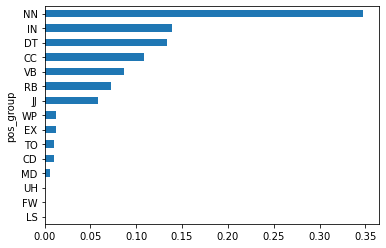

In [28]:
PI.sort_values('cp', ascending=True).cp.plot.barh();

## Create Table of $t_n \rightarrow o_n$ Emissions ($ B $)

In [29]:
B = TOKEN[['pos_group', 'term_str']].value_counts().to_frame('n').sort_index()
B.index.names = ['pos_group_y', 'term_str']
B['cp'] = B.n / B.groupby('pos_group_y').n.sum()

In [30]:
B.head()

n        cp
pos_group_y term_str               
CC          a           1  0.000012
            acquired    1  0.000012
            ah          1  0.000012
            all         2  0.000025
            altogether  3  0.000037

In [31]:
BM = B.cp.unstack(fill_value=0)

In [32]:
BM

term_str,0,1,10,100,1000,10000,10440,10800,10th,118952,...,zoroaster,zozo,zuma,zur,à,æneas,æniad,æson,æsops,ł20000
pos_group_y,,,,,,,,,,,,,,,,,,,,,
CC,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
CD,0.000166,0.001247,0.000499,0.000166,0.000166,0.000249,0.000083,0.000166,0.000166,0.000083,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
DT,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
EX,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
FW,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
IN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
JJ,0.000000,0.000006,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000006,0.000000,0.000000,0.000000,0.000000,0.000000
LS,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
MD,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


# Implement Viterbi

<img src="images/viterbi.png" width="750">

<img src="formula.png" width="400">

## Define function 

In [44]:
def viterbi(sent_str, print_results=True):
    
    global POS_GROUP, AM, BM, PI
    
    # Get states (POS types)
    states = AM.index.to_list()
    
    # Get words from sentence (the observed sequence)
    sent_str = sent_str.replace('-', ' ').lower().strip()
    W = [re.sub(r'[\W_]+', '', w) for w in sent_str.split()]
    T = len(W)
    
    # Initialize the lattice 
    lattice = pd.DataFrame(0., columns=range(T), index=states)
    lattice.index.name = 's_type'
    
    # Fit the model to the sentence
    
    # The first time around we use the values in PI
    lattice[0] = PI.cp * BM[W[0]]
    
    # After the first time, we compute the probability of each state
    # using A, B, and the previous term in the lattice to influence A
    for t in range(1, T):
        w = W[t]
        for j in states:
            lattice.loc[j,t] = (lattice[t-1] * AM[j]).max() * BM.loc[j,w]         
    
    # Clean up
    lattice = lattice.fillna(0)

    # Create path dataframe
    path = lattice.idxmax().to_frame('s')
    path.index.name = 't'
    path['o'] = W
    path['p'] = lattice.sum()
    path['i'] = np.log2(1/path.p)
    
    # Compute perplexity
    pp = 2**(path.i.sum() / T)
    
    # Create result string
    result = ' '.join(path.apply(lambda x: f"{x.o}/{x.s}", 1).to_list())
    if print_results:
        print(f"{result} ({pp})\n")
    
    return lattice, path, result, pp

# Try it out

In [45]:
test_sentences = """
the quick brown fox jumped over the lazy dogs
The event had every promise of happiness for her friend 
Mr Weston was a man of unexceptionable character easy fortune suitable age and pleasant manners
and there was some satisfaction in considering with what self-denying generous friendship she had always wished and promoted the match
but it was a black morning's work for her 
The want of Miss Taylor would be felt every hour of every day 
She recalled her past kindness the kindness the affection of sixteen years 
how she had taught and how she had played with her from five years old 
how she had devoted all her powers to attach and amuse her in health 
and how nursed her through the various illnesses of childhood 
A large debt of gratitude was owing here 
but the intercourse of the last seven years 
the equal footing and perfect unreserve which had soon followed Isabella's marriage 
on their being left to each other was yet a dearer tenderer recollection 
She had been a friend and companion such as few possessed intelligent well-informed useful gentle 
knowing all the ways of the family 
interested in all its concerns 
and peculiarly interested in herself in every pleasure every scheme of hers 
one to whom she could speak every thought as it arose 
and who had such an affection for her as could never find fault 
How was she to bear the change 
It was true that her friend was going only half a mile from them 
but Emma was aware that great must be the difference between a Mrs Weston 
only half a mile from them 
and a Miss Taylor in the house 
and with all her advantages natural and domestic 
she was now in great danger of suffering from intellectual solitude 
She dearly loved her father 
but he was no companion for her 
He could not meet her in conversation rational or playful 
The evil of the actual disparity in their ages
and Mr Woodhouse had not married early
was much increased by his constitution and habits 
for having been a valetudinarian all his life 
without activity of mind or body 
he was a much older man in ways than in years 
and though everywhere beloved for the friendliness of his heart and his amiable temper 
his talents could not have recommended him at any time 
Her sister though comparatively but little removed by matrimony 
being settled in London only sixteen miles off was much beyond her daily reach 
and many a long October and November evening must be struggled through at Hartfield 
before Christmas brought the next visit from Isabella and her husband 
and their little children to fill the house and give her pleasant society again 
""".split('\n')[1:-1]

## Single sentence

In [46]:
lattice, path, result, pp = viterbi(test_sentences[0])

the/DT quick/JJ brown/NN fox/NN jumped/VB over/IN the/DT lazy/JJ dogs/NN (5.64837641340749e+16)



In [47]:
path[['s','o']].T

t,0,1,2,3,4,5,6,7,8
s,DT,JJ,NN,NN,VB,IN,DT,JJ,NN
o,the,quick,brown,fox,jumped,over,the,lazy,dogs


In [48]:
lattice.style.background_gradient()

t,0,1,2,3,4,5,6,7,8
s_type,,,,,,,,,
CC,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
CD,0.000007,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
DT,0.070934,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
EX,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
FW,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
IN,0.000002,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
JJ,0.000079,0.000014,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
LS,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
MD,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [49]:
path.style.background_gradient()

,s,o,p,i
t,,,,
0,DT,the,0.071522,3.805474
1,JJ,quick,0.000022,15.486783
2,NN,brown,0.000000,30.204725
3,NN,fox,0.000000,47.817017
4,VB,jumped,0.000000,63.075810
5,IN,over,0.000000,71.770765
6,DT,the,0.000000,74.853698
7,JJ,lazy,0.000000,89.527213
8,NN,dogs,0.000000,104.296686


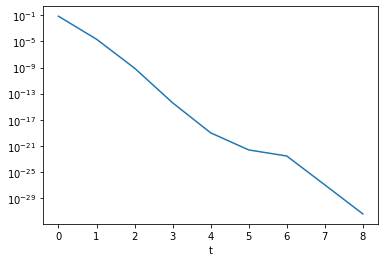

In [50]:
path.p.plot(logy=True);

## All the sentences

In [51]:
S = []
for sent_str in test_sentences:
    a, b, c, d = viterbi(sent_str, print_results=False)
    S.append((c,d))
S = pd.DataFrame(S, columns=['sent_str','pp'])

In [52]:
S.sort_values('pp').sent_str.to_list()

['and/CC a/DT miss/NN taylor/NN in/IN the/DT house/NN',
 'but/CC the/DT intercourse/NN of/IN the/DT last/JJ seven/CD years/NN',
 'interested/JJ in/IN all/DT its/NN concerns/NN',
 'but/CC he/NN was/VB no/DT companion/NN for/IN her/NN',
 'and/CC mr/NN woodhouse/NN had/VB not/RB married/VB early/JJ',
 'only/RB half/JJ a/DT mile/NN from/IN them/NN',
 'without/IN activity/NN of/IN mind/NN or/CC body/NN',
 'and/CC with/IN all/DT her/NN advantages/NN natural/JJ and/CC domestic/JJ',
 'how/NN was/VB she/NN to/TO bear/VB the/DT change/NN',
 'knowing/VB all/DT the/DT ways/NN of/IN the/DT family/NN',
 'she/NN dearly/RB loved/VB her/NN father/NN',
 'but/CC it/NN was/VB a/DT black/JJ mornings/NN work/NN for/IN her/NN',
 'the/DT evil/NN of/IN the/DT actual/JJ disparity/NN in/IN their/NN ages/NN',
 'a/DT large/JJ debt/NN of/IN gratitude/NN was/VB owing/VB here/RB',
 'for/IN having/VB been/VB a/DT valetudinarian/JJ all/DT his/NN life/NN',
 'was/VB much/JJ increased/VB by/IN his/NN constitution/NN and/C